# Clustering

Vamos a realizar operaciones de **clustering** (segmentación) de datos.
La idea es encontrar una estructura dentro de un dataset donde originalmente no la había.
No se tiene un objetivo de predicción (se trata **aprendizaje no supervisado**), sino de uno de entendimiento de los datos a través del particionamiento del dataset en grupos de instancias.

Para poder entender como se utilizan los algoritmos de clustering, vamos a crear un dataset sintético con datos ficticios que nos permita ilustrar los aspectos de llamado a los métodos de python.

Vamos a generar y visualizar en un plot 300 puntos aleatorios distribuidos alrededor de 4 centros en un espacio bidimensional, con una desviación estándar de 0.7. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from collections import Counter
from time import time


from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn import preprocessing
from sklearn.decomposition import PCA

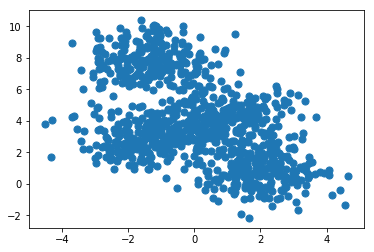

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, grupo = make_blobs(n_samples=1000, centers=4, cluster_std=1, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

En X van a quedar las coordenadas de los puntos y en **grupo** los clusters originales a los que pertencen los datos.

In [3]:
X[0:5]

array([[-2.50804312,  7.86408052],
       [ 0.4666179 ,  3.86571303],
       [-2.94062621,  8.56480636],
       [-2.89994656,  1.85014025],
       [ 2.34438803,  1.31053448]])

In [4]:
grupo[0:5]

array([3, 0, 3, 2, 1])

## Scikit-learn

El algoritmo de Clustering Jerárquico (AgglomerativeClustering en Scikit-Learn) recibe como parámetro el tipo de fusión de clusters y el número de clusters que se buscan (hay que especificarlo ya que no lo determina automáticamente). Como sabemos que los datos sintéticos se crearon con 4 grupos, vamos a analizar si HClust los logra detectar.

Vamos a intentar con diferentes tipos de métodos de fusión (un modelo para cada fusión) para entender sus diferencias al analizar los resultados. Comparamos los resultados entre ellos y también con respecto a KMeans.

Text(0.5, 1.0, 'K-Means')

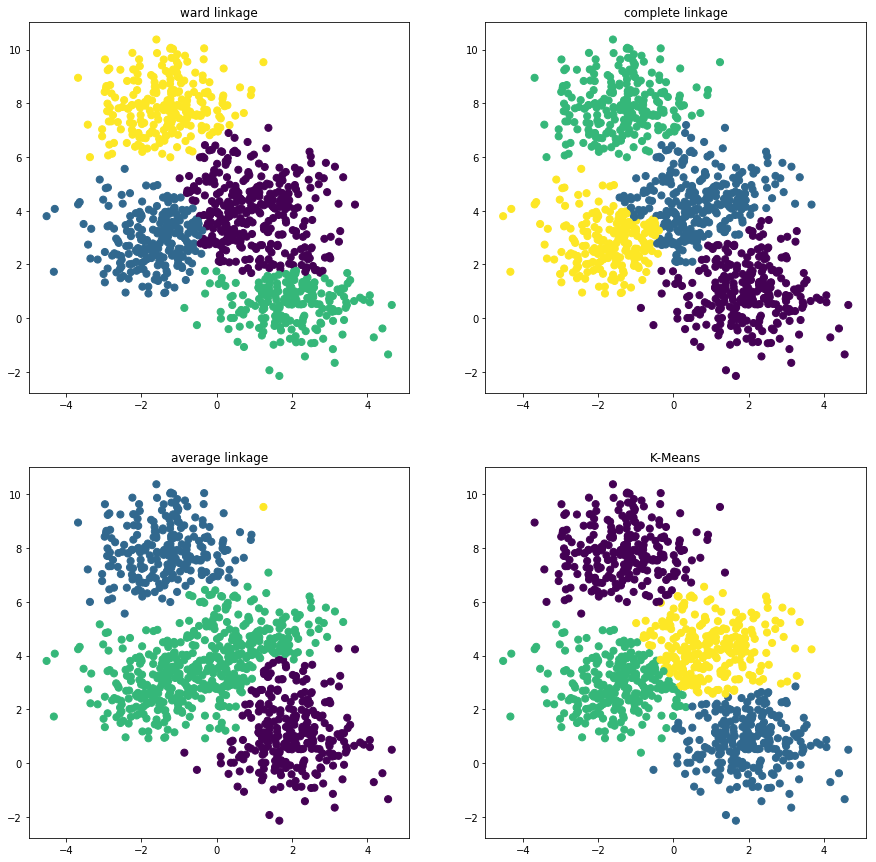

In [5]:
fig, axes = plt.subplots(2,2,figsize=(15,15))

link = 'ward'
clustering = AgglomerativeClustering(linkage=link, n_clusters=4)
clustering.fit(X)
axes[0][0].scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=50, cmap='viridis')
axes[0][0].set_title("%s linkage" % link)

link = 'complete'
clustering = AgglomerativeClustering(linkage=link, n_clusters=4)
clustering.fit(X)
axes[0][1].scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=50, cmap='viridis')
axes[0][1].set_title("%s linkage" % link)

link = 'average'
clustering = AgglomerativeClustering(linkage=link, n_clusters=4)
clustering.fit(X)
axes[1][0].scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=50, cmap='viridis')
axes[1][0].set_title("%s linkage" % link)

clustering = KMeans(n_clusters=4)
clustering.fit(X)
axes[1][1].scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=50, cmap='viridis')
axes[1][1].set_title("K-Means")

El problema de **Scikit-learn** es que no incluye otros métodos de fusión (e.g. Single) y no incluye un método de visualización de dendrogramas.

Vamos ahora a utilizar la librería **scipy**, que es mas versátil.

## Scipy

Scipy dispone de la función **linkage** que resume las diferentes fusiones realizadas (son n-1 fusiones), utilizando el método de fusión indicado como parámetro. El resultado de la función linkage es una matriz de 4 columnas:
- Índice del primer cluster a fusionar
- Índice del segundo cluster a fusionar
- Distancia de fusión según el método indicado
- Número de elementos atómicos incluidos en el cluster fusionado

In [6]:
# generate the linkage matrix
fusiones = linkage(X, 'ward')

Vemos entonces que las 5 primeras fusiones aglomeran clusters de tamaño 1 (puntos atómicos), ya que el tamaño final de la aglomeración es 2). Vemos también que las distancias de fusión de la 3a columna van a estar siempre en orden creciente; en el dendrograma se vana utilizar para definir la altura de las ramas.

In [7]:
fusiones[-5:]

array([[1979.        , 1984.        ,   17.87049166,  192.        ],
       [1991.        , 1994.        ,   24.47750899,  330.        ],
       [1993.        , 1995.        ,   47.19995944,  555.        ],
       [1990.        , 1996.        ,   63.04949598,  760.        ],
       [1992.        , 1997.        ,  105.39177182, 1000.        ]])

Vemos que en las últimas fusiones las distancias son muchísmo mas grandes, y que las aglomeraciones tienen una cardinalidad elevada, finalizando en un cluster con la última fusión de los 1000 puntos totales.
Además los índices sobrepasan el valor de 1000, refiriéndose a clusters previamente aglomerados y no a elementos atómicos, siguiendo el mismo orden de aglomeración.

### Dendrogramas

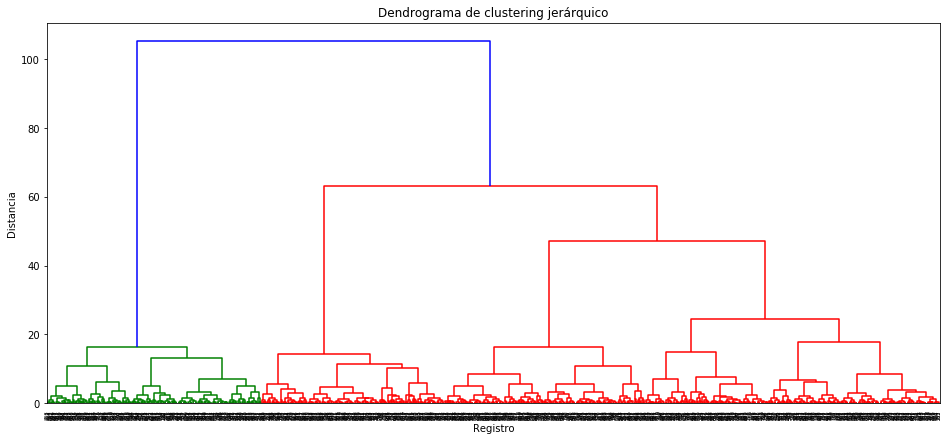

In [8]:
plt.figure(figsize=(16, 7))  
plt.title('Dendrograma de clustering jerárquico')
plt.xlabel('Registro')
plt.ylabel('Distancia')
dendrogram(fusiones,  
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

Vamos a tomar prestada una función encontrada en https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ que permite reutilizar los datos devueltos por la función dendrograma para mejorar los dendrogramas:

In [9]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

Vamos a indicar el K que creemos conveniente especificando la distancia correspondiente (para k=4 tenemos d=30), a solamente considerar los últimos 50 clusters, truncando el resto de tal manera que en las hojas del dendrograma podemos consultar el tamaño de cada cluster truncado:

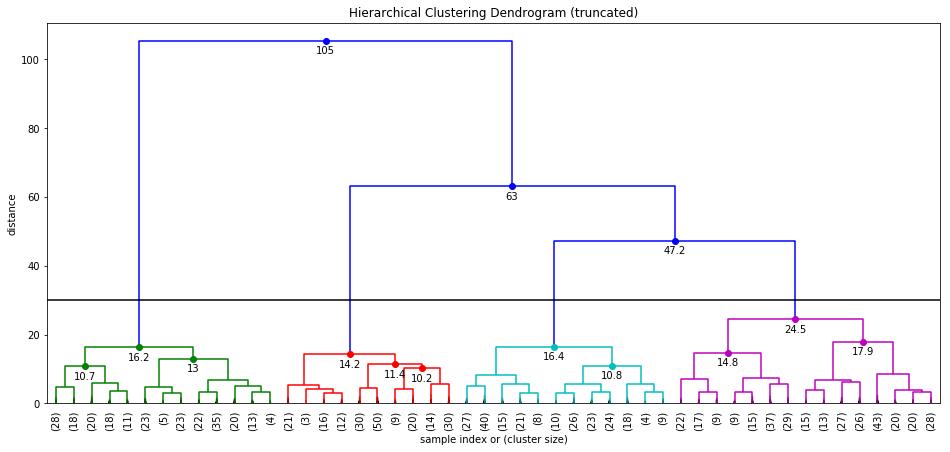

In [10]:
plt.figure(figsize=(16, 7))  
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=30,  # plot a horizontal cut-off line
)


In [ ]:
plt.figure(figsize=(16, 7))  
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=4,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10
)

### Obtener los clusters

Encontramos entonces 4 clusters con 240, 205, 225 y 330 puntos cada uno.

Para obtener el cluster de cada punto, lo podemos obtener de dos manera, ya sea a partir de la distancia de fusión ("distance")  o a partir del número de clusters ("maxclust") que se deseen:

In [11]:
max_d = 30 #para criterion="distance"
k = 4
clusters = fcluster(fusiones, k, criterion='maxclust')
clusters

array([1, 4, 1, 3, 2, 4, 4, 2, 4, 4, 1, 4, 3, 1, 4, 3, 3, 1, 4, 4, 3, 1,
       2, 2, 2, 3, 4, 2, 2, 3, 2, 4, 1, 3, 4, 4, 1, 4, 4, 3, 4, 4, 4, 3,
       1, 4, 4, 1, 3, 4, 2, 4, 4, 3, 1, 4, 4, 4, 1, 1, 2, 4, 3, 3, 4, 1,
       4, 3, 1, 1, 1, 1, 1, 2, 4, 1, 4, 1, 3, 2, 4, 3, 4, 4, 2, 3, 4, 4,
       3, 3, 1, 3, 3, 1, 4, 1, 3, 2, 4, 4, 2, 3, 4, 2, 4, 3, 4, 1, 3, 4,
       4, 4, 3, 1, 3, 3, 4, 3, 2, 2, 2, 1, 3, 4, 4, 2, 4, 1, 3, 4, 2, 4,
       3, 4, 4, 4, 3, 4, 4, 1, 2, 4, 2, 4, 4, 4, 2, 4, 1, 1, 2, 4, 4, 4,
       3, 2, 4, 4, 2, 3, 1, 2, 4, 4, 4, 4, 1, 1, 4, 2, 3, 2, 4, 2, 3, 4,
       3, 4, 2, 4, 3, 4, 3, 4, 4, 3, 2, 4, 2, 1, 3, 4, 4, 2, 4, 1, 3, 1,
       3, 3, 4, 4, 1, 1, 2, 2, 3, 4, 1, 4, 4, 3, 4, 1, 3, 4, 4, 2, 2, 4,
       4, 4, 4, 1, 3, 4, 4, 4, 1, 1, 4, 4, 4, 4, 3, 2, 3, 2, 2, 3, 4, 3,
       2, 4, 1, 1, 1, 1, 1, 1, 4, 3, 1, 3, 3, 2, 3, 4, 1, 1, 2, 1, 4, 2,
       1, 3, 4, 3, 1, 2, 2, 4, 2, 3, 1, 1, 3, 1, 3, 4, 4, 1, 3, 4, 3, 3,
       3, 4, 4, 1, 2, 3, 4, 1, 1, 4, 1, 2, 4, 1, 2,

### Comparación de los diferentes métodos de fusión disponibles en SciPy

In [12]:
X.shape
X[0:5]

array([[-2.50804312,  7.86408052],
       [ 0.4666179 ,  3.86571303],
       [-2.94062621,  8.56480636],
       [-2.89994656,  1.85014025],
       [ 2.34438803,  1.31053448]])

Text(0.5, 1.0, 'weighted linkage')

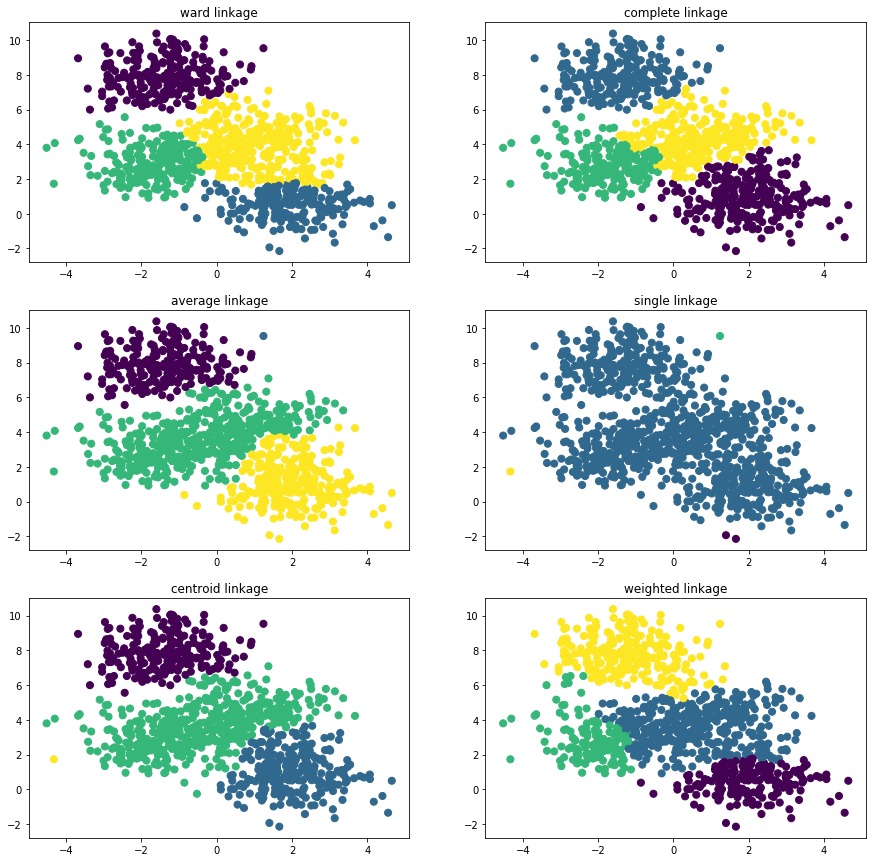

In [13]:
k = 4
fig, axes = plt.subplots(3,2,figsize=(15,15))

link = 'ward'
fusiones = linkage(X, link)
clusters = fcluster(fusiones, k, criterion='maxclust')
axes[0][0].scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
axes[0][0].set_title("%s linkage" % link)

link = 'complete'
fusiones = linkage(X, link)
clusters = fcluster(fusiones, k, criterion='maxclust')
axes[0][1].scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
axes[0][1].set_title("%s linkage" % link)

link = 'average'
fusiones = linkage(X, link)
clusters = fcluster(fusiones, k, criterion='maxclust')
axes[1][0].scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
axes[1][0].set_title("%s linkage" % link)

link = 'single'
fusiones = linkage(X, link)
clusters = fcluster(fusiones, k, criterion='maxclust')
axes[1][1].scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
axes[1][1].set_title("%s linkage" % link)

link = 'centroid'
fusiones = linkage(X, link)
clusters = fcluster(fusiones, k, criterion='maxclust')
axes[2][0].scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
axes[2][0].set_title("%s linkage" % link)

link = 'weighted'
fusiones = linkage(X, link)
clusters = fcluster(fusiones, k, criterion='maxclust')
axes[2][1].scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
axes[2][1].set_title("%s linkage" % link)

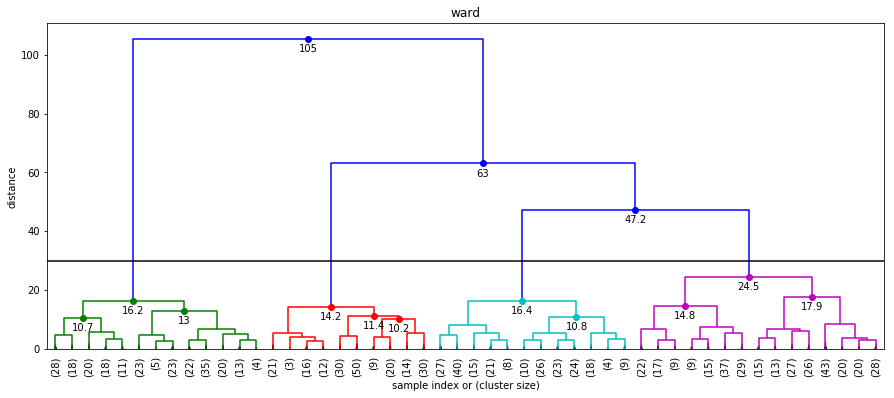

In [14]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'ward'
fusiones = linkage(X, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=30,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

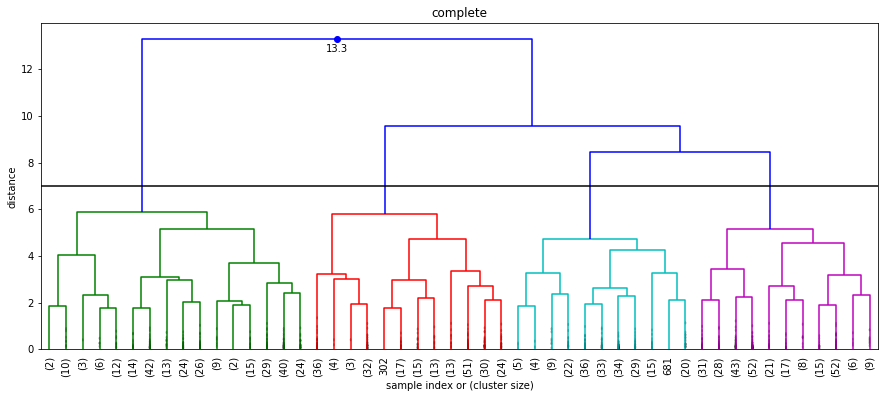

In [15]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'complete'
fusiones = linkage(X, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=7,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

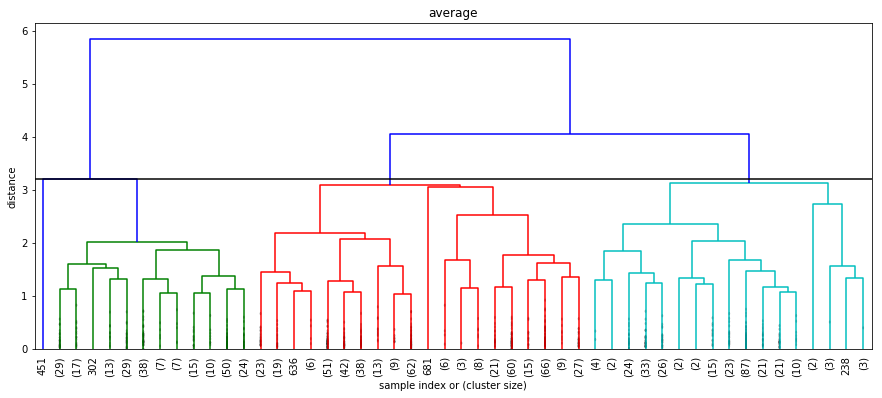

In [16]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'average'
fusiones = linkage(X, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=3.2,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

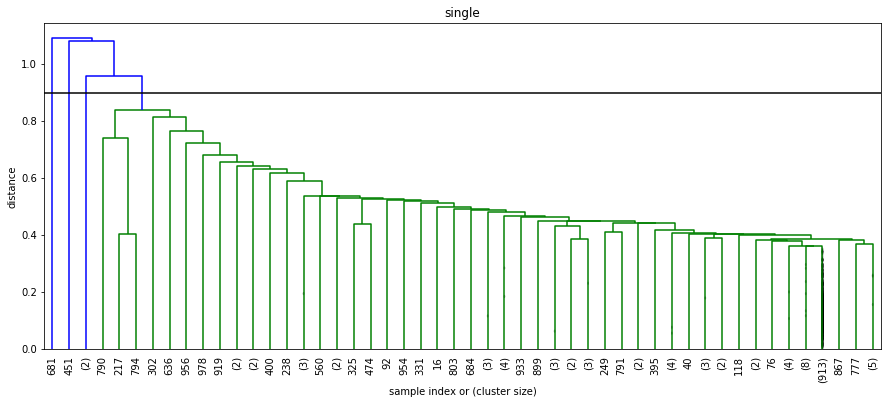

In [17]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'single'
fusiones = linkage(X, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=0.9,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

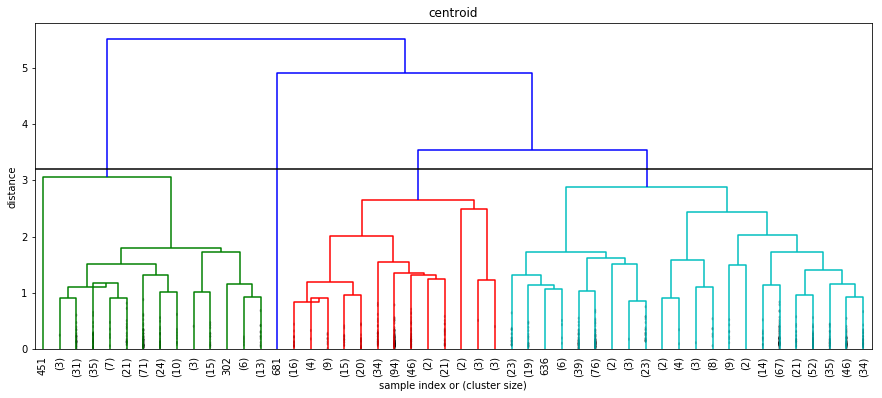

In [18]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'centroid'
fusiones = linkage(X, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=3.2,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()

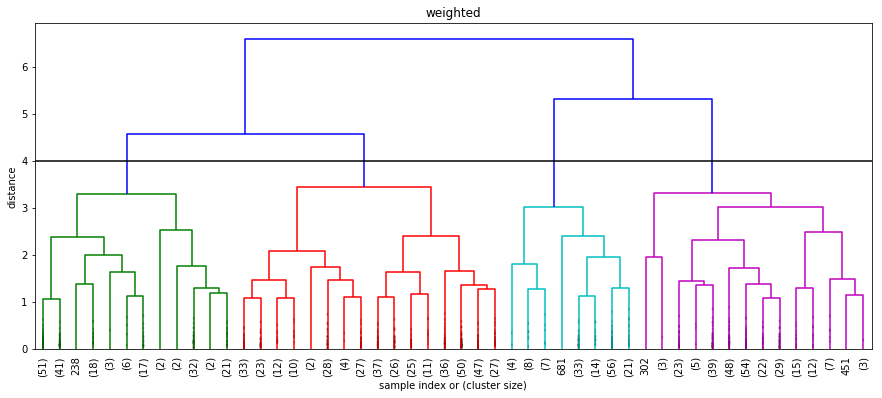

In [19]:
fig, axes = plt.subplots(figsize=(15,6))
link = 'weighted'
fusiones = linkage(X, link)
fancy_dendrogram(
    fusiones,
    truncate_mode='lastp',
    p=50,
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,
    annotate_above=10,
    max_d=4,  # plot a horizontal cut-off line
)
plt.title(link)
plt.show()